In [1]:
from cheetah import Segment, ParticleBeam
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9),
)

segment = Segment.from_lattice_json("diag0.json")

front_segment = Segment(
    elements=segment.elements[:162],
)
reconstruction_beam = front_segment.track(beam)

In [2]:
diag0_reconstruction = Segment.from_lattice_json("diag0_reconstruction.json")

nominal_val = 6.83
quad_strengths = torch.linspace(nominal_val*0.5, nominal_val*1.5, 7)
diag0_reconstruction.qdg006.k1 = quad_strengths

diag0_reconstruction.track(reconstruction_beam);



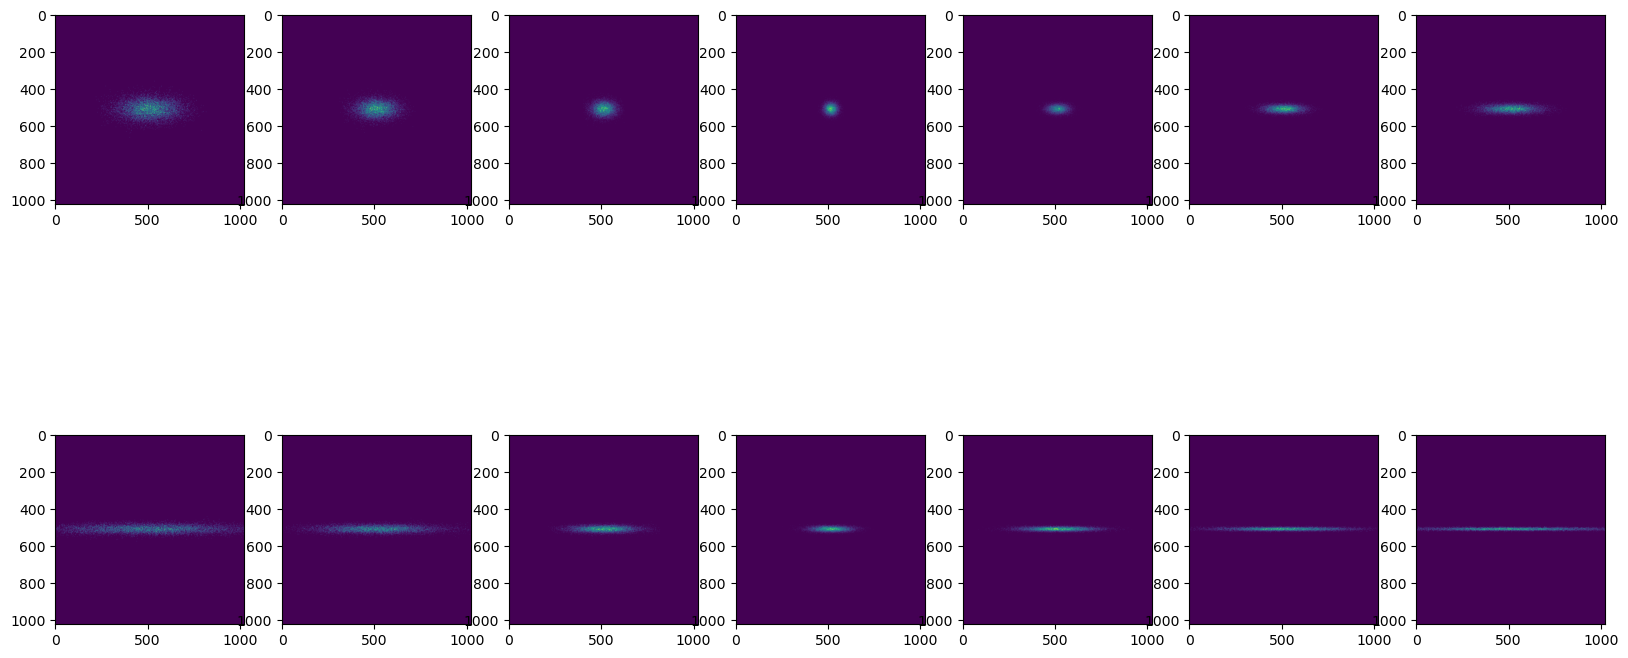

In [3]:
import matplotlib.pyplot as plt
otr2_data = diag0_reconstruction.otrdg02.reading
otr4_data = diag0_reconstruction.otrdg04.reading

# plot all images
fig, axs = plt.subplots(2, 7, figsize=(20, 10))
for i in range(7):
    axs[0, i].imshow(otr2_data[i])
    axs[1, i].imshow(otr4_data[i])

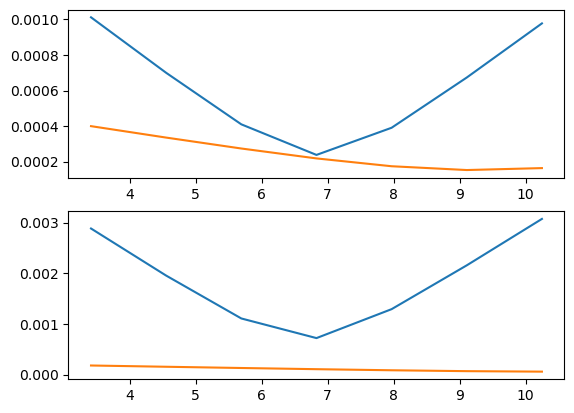

In [4]:
fig,ax = plt.subplots(2,1)

for i, ele in enumerate([diag0_reconstruction.otrdg02, diag0_reconstruction.otrdg04]):
    ax[i].plot(diag0_reconstruction.qdg006.k1, ele.get_read_beam().sigma_x)
    ax[i].plot(diag0_reconstruction.qdg006.k1, ele.get_read_beam().sigma_y)

In [19]:
from gpsr.modeling import GPSRLattice

class DIAG0Lattice(GPSRLattice):
    def __init__(self):
        super().__init__()
        self.lattice = Segment.from_lattice_json("diag0_reconstruction.json")

    def track_and_observe(self, beam):
        self.lattice.transfer_maps_merged(beam)

        return self.lattice.otrdg02.reading, self.lattice.otrdg04.reading
    
    def set_lattice_parameters(self, x):
        # set quad parameters
        self.lattice.qdg006.k1 = x



from gpsr.datasets import ObservableDataset
from typing import List

class DIAG0Dataset(ObservableDataset):
    def __init__(self, parameters, observations):
        self.parameters = parameters
        self.observations = observations

        self._flattened_parameters = parameters

    def __len__(self):
        return self._flattened_parameters.shape[0]

    def __getitem__(self, idx) -> (torch.Tensor, List[torch.Tensor]):
        return (
            self._flattened_parameters.reshape(1,1,-1)[..., idx],
            [ele[idx] for ele in self.observations],
        )


# input quad strengths should be 2,2,7
train_dataset = DIAG0Dataset(
    quad_strengths,
    (otr2_data, otr4_data)
)

In [20]:
import torch
import lightning as L
from gpsr.custom_cheetah.screen import Screen
from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import QuadScanDataset

In [21]:
p0c = reconstruction_beam.p0c
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), DIAG0Lattice())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

C:\Users\Ryan Roussel\Documents\GitHub\gpsr\gpsr\beams.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("beam_energy", torch.tensor(energy))
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode
c:\ProgramData\mambaforge\envs\ml-tto\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increas

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [25]:
litgpsr.training_step(next(iter(train_loader)),0)

tensor(3.3041e-06, grad_fn=<AddBackward0>)